In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import (
    pearsonr,
    f_oneway,
    ttest_ind,
    chi2_contingency,
    spearmanr,
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PolynomialFeatures,
)
from sklearn.base import BaseEstimator, TransformerMixin
import pingouin as pg
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error
from sklearn import set_config

set_config(transform_output="pandas")
train_set = pd.read_csv("kaggle_train_set.csv")
train_set.head()

,OverallQual,GrLivArea,TotalBsmtSF,1stFlrSF,YearBuilt,YearRemodAdd,GarageCars,GarageArea,FullBath,TotRmsAbvGrd,KitchenQual,Fireplaces,LotArea,Neighborhood,ExterQual,SalePrice
0,7,1710,856,856,2003,2003,2,548,2,8,Gd,0,8450,CollgCr,Gd,208500
1,6,1262,1262,1262,1976,1976,2,460,2,6,TA,1,9600,Veenker,TA,181500
2,7,1786,920,920,2001,2002,2,608,2,6,Gd,1,11250,CollgCr,Gd,223500
3,8,1694,1686,1694,2004,2005,2,636,2,7,Gd,1,10084,Somerst,Gd,307000
4,7,1774,952,1022,1931,1950,2,468,2,8,TA,2,6120,OldTown,TA,129900


Dans ce projet, nous n’effectuerons pas de split : le dataset est déjà séparé en deux fichiers distincts, kaggle_train_set.csv pour l’entraînement et kaggle_test_set.csv pour le test.

In [196]:
train_set.isna().sum(axis=0)

OverallQual     0
GrLivArea       0
TotalBsmtSF     0
1stFlrSF        0
YearBuilt       0
YearRemodAdd    0
GarageCars      0
GarageArea      0
FullBath        0
TotRmsAbvGrd    0
KitchenQual     0
Fireplaces      0
LotArea         0
Neighborhood    0
ExterQual       0
SalePrice       0
dtype: int64

In [197]:
train_set["Neighborhood"].unique()

array(['CollgCr', 'Veenker', 'Somerst', 'OldTown', 'BrkSide', 'NridgHt',
       'Sawyer', 'NAmes', 'SawyerW', 'IDOTRR', 'Edwards', 'Timber',
       'Mitchel', 'Gilbert', 'StoneBr', 'ClearCr', 'Crawfor', 'NWAmes',
       'NPkVill', 'Blmngtn', 'BrDale', 'NoRidge', 'SWISU', 'MeadowV',
       'Blueste'], dtype=object)

On constate l’absence de valeurs manquantes dans le jeu de données. En recherchant sur internet, on peut trouver des dataset similaires qui présente les prix des maisons d'AMES en IOWA au Etats-unis avec plus de variables. On peut donc ce dire que les maisons de ce jeu de données sont en Amérique et donc les prix sont en dollards et les surface en pied².
# I) Explication des variables

• OverallQual : Qualité globale des matériaux et de la finition, généralement très corrélée au prix de vente (note entière sur 10).  (discret)

• GrLivArea : Surface habitable hors sous-sol, directement liée à la taille de la maison. (continue)

• TotalBsmtSF : Superficie totale du sous-sol, ajoutant une valeur significative à la propriété. (continue)

• 1stFlrSF : Superficie du rez-de-chaussée, indicateur de la taille de la maison. (continue)

• YearBuilt : Année de construction ; les maisons plus récentes ont tendance à se vendre plus cher. (Discret)

• YearRemodAdd : Année de rénovation ; des rénovations récentes peuvent augmenter le prix. (Discret)

• GarageCars : Capacité du garage (nombre de voitures), un élément clé pour de nombreux acheteurs. (Discret)

• GarageArea : Taille du garage en pieds carrés. (continue)

• FullBath : Nombre de salles de bains complètes, facteur important pour le confort de la maison. (discret)

• TotRmsAbvGrd : Nombre total de pièces au-dessus du sol (hors salles de bains) ; plus il y en a, plus le bien est généralement cher. (discret)

• KitchenQual : Qualité de la cuisine ; une cuisine de haute qualité ajoute de la valeur. (discret)

• Fireplaces : Nombre de cheminées, caractéristique pouvant accroître l’attrait et la valeur d’une propriété. (discret)

• LotArea : Surface totale du terrain ; facteur important, notamment en zone urbaine. (continue)

• Neighborhood : Emplacement physique au sein des limites de la ville d'Ames en Iowa; l’emplacement a un impact majeur sur les prix. (discret)

• ExterQual : Qualité du matériau extérieur, indicateur de la qualité globale de la maison. (discret)

• SalePrice : Prix de vente de la maison, variable cible à prédire. Il n’y a que des maisons dans le jeu de données. (continue)

# II) Analyse statistique

Dans ce dataset on a des variables de surfaces, de temps, de nombre d'éléments, de qualité et une variable de lieu. On va faire l'analyse par groupe de variable en faisant toujours une analyse univariées, une analyse mutlivarié avec la target et l'analyse des variables entre-eux à chaque fois. On va d'abords analyser la target puis les variables de surfaces car elles sont logiquement trés corrélée. Le premier but serait de voir les variables corrélés avec le prix mais aussi de voir on peut créer des sous groupe. C'est pour cela que on commence par les variables continue puis en deuxiéme on fera les variables de temps car en fonction de l'analyse on pourrat faire des surfaces scatter intéréssant. Ensuite on peut faire le voisinage car le oisinage est une variable techniquement purement catégoriel dans lequel on peut peut-être créer d'autre sous groupe. On peut envisager deux façons d'étudier le voisinage. On peut classer chaque voisinage par prix croissant moyen des maisons, ce qui va créer une variable ordinal mais on peut essayer d'analyser de maniére catégoriel. En fonction de l'analyse on envisagera lequel des deux stratégie on utilisera. Ensuite les variables de qualités car logiquement la qualité sont des variable logiquement au prix et en dernier on fera les variables de nombres d'éléments.
 
## II.1) Analyse univarié du prix

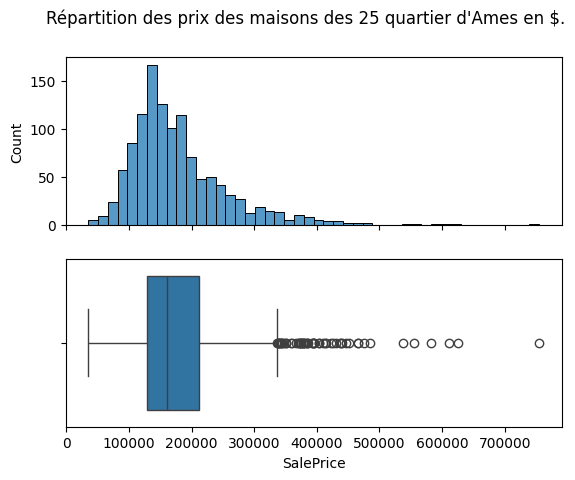

count      1180.000000
mean     179822.169492
std       79703.346024
min       34900.000000
25%      128800.000000
50%      161250.000000
75%      212000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [198]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition des prix des maisons des 25 quartier d'Ames en $.")
sns.histplot(data=train_set, x="SalePrice", ax=ax[0])
sns.boxplot(data=train_set, x="SalePrice", ax=ax[1])
plt.show()
train_set["SalePrice"].describe()

On voit que le prix des maisons de ce jeu de données suivent bien une loi normale. La majorité des maisons ont des prix entre 100000 dollard dollard et 200000 dollard. On observe beaucoup d'outlier proche de la borne de droite et qui sont proche les uns des autres. On voit un autre groupe de 4 outlier un peu plus loin et on voit tous à droite un outliers trés éloignés. La moyenne de prix des maisons des 25 quartier d'Ames est de 179822.169492 dollard avec un écart-type de 79703.346024 dollard. Le minimum est de 34900 dollards et le maximum est de 755000 dollard. On va maintenant faire l'analyse complête des variables de surfaces.

## II.2) Analyse des variables de surfaces

### II.2.1) Analyse univarié

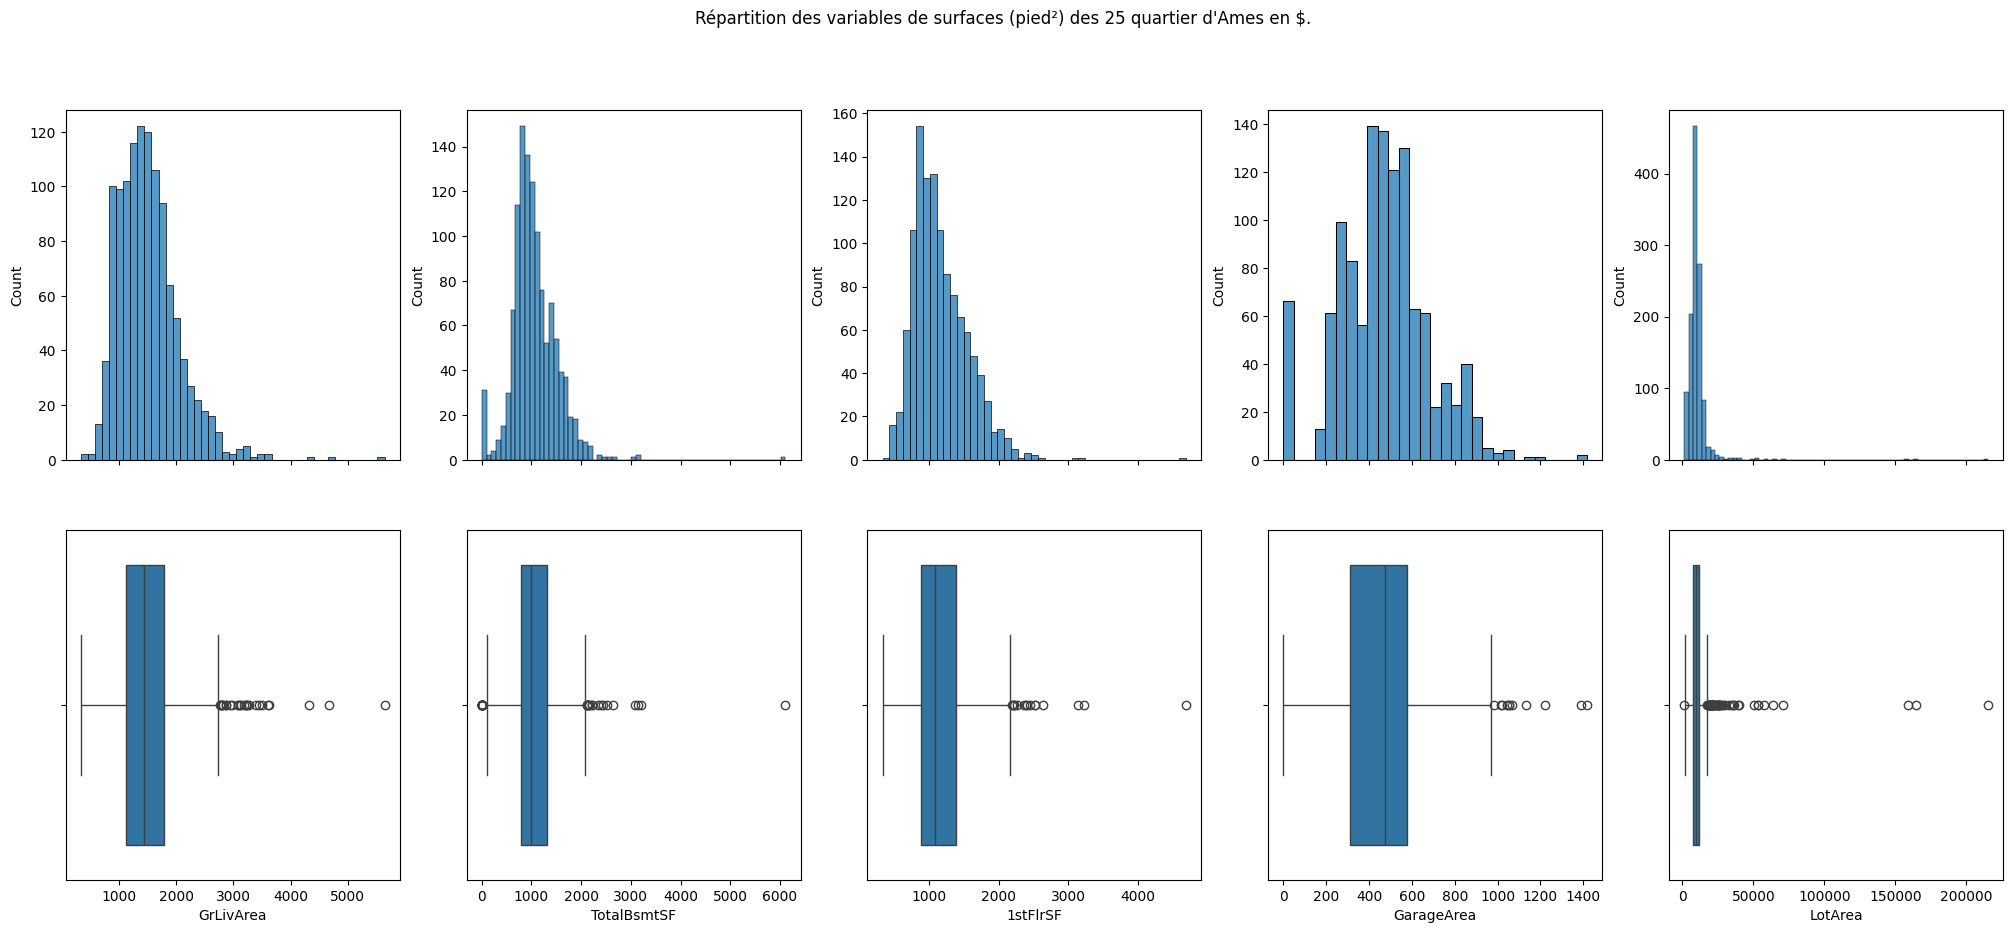

,GrLivArea,TotalBsmtSF,1stFlrSF,GarageArea,LotArea
count,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000
mean,1508.277966,1058.874576,1163.179661,468.944915,10448.989831
std,534.634371,448.648614,395.100829,211.898970,10266.492616
min,334.000000,0.000000,334.000000,0.000000,1300.000000
25%,1118.000000,793.000000,879.750000,312.000000,7500.000000
50%,1441.500000,993.500000,1088.000000,474.000000,9458.500000
75%,1779.000000,1309.500000,1392.000000,576.000000,11532.750000
max,5642.000000,6110.000000,4692.000000,1418.000000,215245.000000


In [199]:
fig, ax = plt.subplots(2, 5, sharex="col")
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition des variables de surfaces (pied²) des 25 quartier d'Ames en $."
)
sns.histplot(data=train_set, x="GrLivArea", ax=ax[0, 0])
sns.boxplot(data=train_set, x="GrLivArea", ax=ax[1, 0])
sns.histplot(data=train_set, x="TotalBsmtSF", ax=ax[0, 1])
sns.boxplot(data=train_set, x="TotalBsmtSF", ax=ax[1, 1])
sns.histplot(data=train_set, x="1stFlrSF", ax=ax[0, 2])
sns.boxplot(data=train_set, x="1stFlrSF", ax=ax[1, 2])
sns.histplot(data=train_set, x="GarageArea", ax=ax[0, 3])
sns.boxplot(data=train_set, x="GarageArea", ax=ax[1, 3])
sns.histplot(data=train_set, x="LotArea", ax=ax[0, 4])
sns.boxplot(data=train_set, x="LotArea", ax=ax[1, 4])

plt.show()
train_set[["GrLivArea", "TotalBsmtSF", "1stFlrSF", "GarageArea", "LotArea"]].describe()

La moyenne de la surface habitable hors sous-sol, de la superrficie totale du sous-sol, de la superficie du rez-de-chaussée, de la taille du garage et de la surface totale du terrain pour les maisons des 25 quartier d'Ames sont respectivement égale à 1508.277966 pied², 1058.874576 pied², 1163.179661 pied ², 468.944915 pied² et 10448.989831 pied² avec respectivement les écart-type 534.634371 pied², 448.648614 pied², 395.100829 pied², 211.898970 pied² et 10266.492616 pied². On voit que le minimum pour la surface habitable hors sous-sol est de 334 pied² soit 31,0296 m² et selon ce site https://immobilier.lefigaro.fr/article/tiny-houses-le-maxi-succes-des-mini-maisons-aux-etats-unis_1595aae4-9298-11e9-908c-e04cf7f68362/ toutes les maisons de moins de 40 m² sont des tiny house et plus en plus d'américain ce dirige vers ce types de maison. On voit que le maximum de surface habitable hors sous-sol est de 5642 pied² soit 524,159 m². On voit que certaine maison n'ont pas de sous-sol car le minimum est de 0 pied² et le plus grand sous-sol est plus grand que la plus grande surface habitable hors sous-sol, ce qui veut dire qu'il y a peut-être pour la maison ayant le maximum de surface de sous-sol, non seulement une habitation mais avec une affaire comme un vignoble ou une ferme. Cela veut dire qu'en fonction du type de quartier, on pourrat dire si il est possible d'avoir une telle maison dans le jeu de donnée. La présence d'une telle maison peut indiquer qu'il y a aussi d'autre maison qui ont leurs sous-sol plus grand que la surface habitable hors sous-sol. La maison qui à le plus petit rez-de-chaussée à la même surface de rez-de-chaussée que la maison qui à la plus petite surface habitable hors sous-sol. Il s'agit peut-être de la même tiny house. La surface maximal de rez-de-chaussée est de 4692 pied². Certaine maison n'ont pas de garage car le minimum est 0 pied². Le maximum de surface de garage est 1418 pied². La surface totale du terrain minmum est de 1300 pied² et la surface totale du terrain maximale est de 215245 pied² qui correspond à 19996,9148 m² qui est quand même une surface extrêmement grande. Une surface trés grande ne veut pas forcément dire que c'est une valeur à enlever car cela dépendré du quartier. On voit que sur les histogrammes, toutes les surfaces suivent une loi normale mais avec des outliers à droite de la distribution. On voit que pour les 3 premiére surfaces on à un groupe d'outliers proche de la borne de droite de la boite à moustache puis un groupe de deux valeurs puis une tous seul loin à droite. On va maintenant regarder les relations de chaque surface avec le prix.

### II.2.2) Analyse multivariée

#### II.2.2.1) Analyse de chaque surface par rapport au prix.

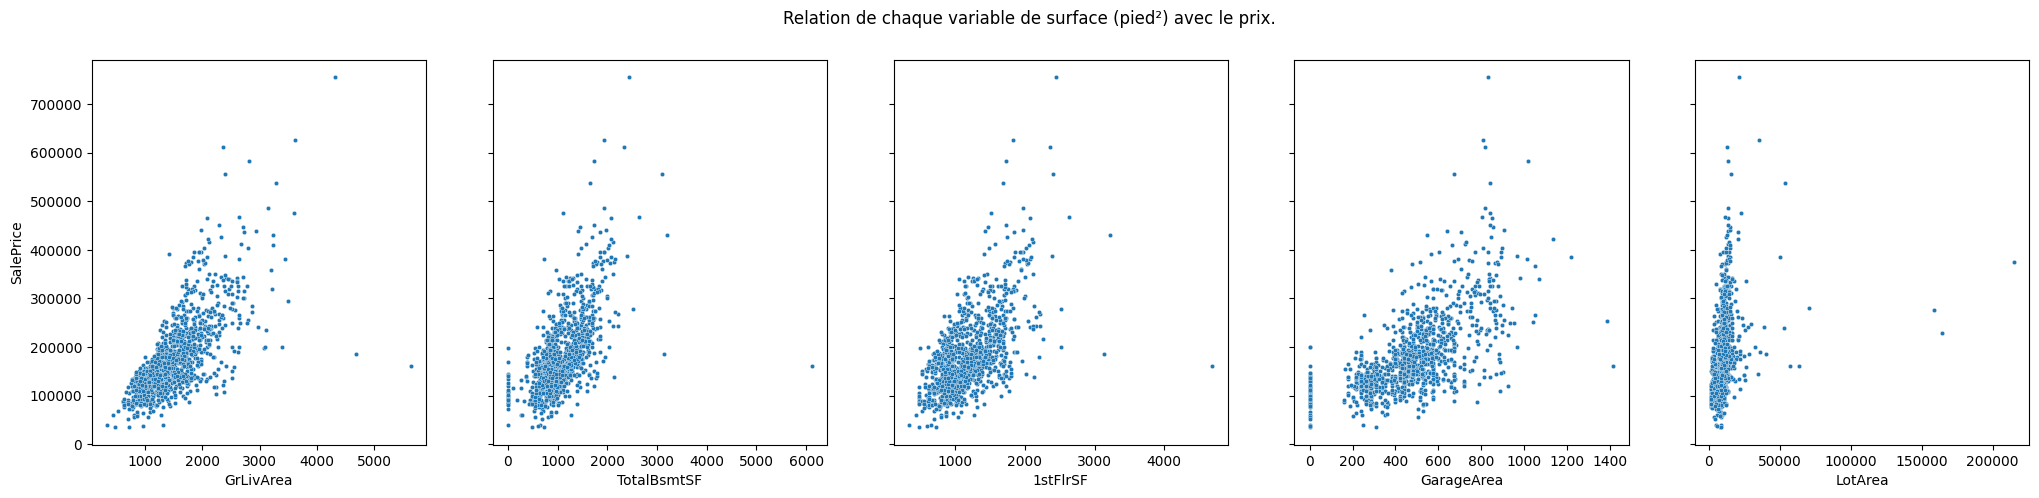

In [200]:
fig, ax = plt.subplots(1, 5, sharey=True)
fig.set_size_inches(25, 5)
plt.suptitle("Relation de chaque variable de surface (pied²) avec le prix.")
sns.scatterplot(data=train_set, x="GrLivArea", y="SalePrice", ax=ax[0], s=10)
sns.scatterplot(data=train_set, x="TotalBsmtSF", y="SalePrice", ax=ax[1], s=10)
sns.scatterplot(data=train_set, x="1stFlrSF", y="SalePrice", ax=ax[2], s=10)
sns.scatterplot(data=train_set, x="GarageArea", y="SalePrice", ax=ax[3], s=10)
sns.scatterplot(data=train_set, x="LotArea", y="SalePrice", ax=ax[4], s=10)
plt.show()

On voit que pour les trois premiére surface on à clairement des relations plutôt linéaire mais avec beaucoup de bruit. Il y a des outliers, deux pour la surface habitable hors sous-sol et seulement une seul pour la superficie totale du sous-sol et pour la superficie du rez-de-chaussée. Pour la relation avec la surface du garage on à plutôt une relation polynomiale. Aucun outliers vraiment loin est présent pour le cas de la surface du garage. On voit une relation linéaire avec une pente trés faible à cause de trois outliers trés éloigné à droite. Pour vraiment valider les relations on va faire un test de pearsonr.

In [201]:
print(
    "Surface habitable hors sous-sol-prix:",
    pearsonr(train_set["GrLivArea"], train_set["SalePrice"]),
)
print(
    "Superficie totale du sous-sol-prix:",
    pearsonr(train_set["TotalBsmtSF"], train_set["SalePrice"]),
)
print(
    "Superficie du rez-de-chaussée-prix:",
    pearsonr(train_set["1stFlrSF"], train_set["SalePrice"]),
)
print(
    "Taille du garage-prix:",
    pearsonr(train_set["GarageArea"], train_set["SalePrice"]),
)
print(
    "Surface totale du terrain-prix:",
    pearsonr(train_set["LotArea"], train_set["SalePrice"]),
)

Surface habitable hors sous-sol-prix: PearsonRResult(statistic=np.float64(0.7057769363696099), pvalue=np.float64(1.4791768764527187e-178))
Superficie totale du sous-sol-prix: PearsonRResult(statistic=np.float64(0.6139115349976293), pvalue=np.float64(3.778003148327125e-123))
Superficie du rez-de-chaussée-prix: PearsonRResult(statistic=np.float64(0.6123894741641841), pvalue=np.float64(2.205085994034628e-122))
Taille du garage-prix: PearsonRResult(statistic=np.float64(0.6398274039873701), pvalue=np.float64(7.253869868317046e-137))
Surface totale du terrain-prix: PearsonRResult(statistic=np.float64(0.2613829457000063), pvalue=np.float64(6.949580292807652e-20))


Selon les p_value, il y a présence de corrélation entre chaque variable de surface et le prix. On à une trés forte corrélation avec la surface habitable hors sous-sol, de forte corrélation avec la totale du sous-sol, la superficie du rez-de-chaussée et la taille du garage puis une corrélation faible avec la surface totale du terrain. Malgré une faible corrélation, la surface totale du terrain sera prise en compte pour le modéle. Regardons maintenant les variables de surfaces entre-eux.

#### II.2.2.2) Analyse des variables de surfaces entre-eux.

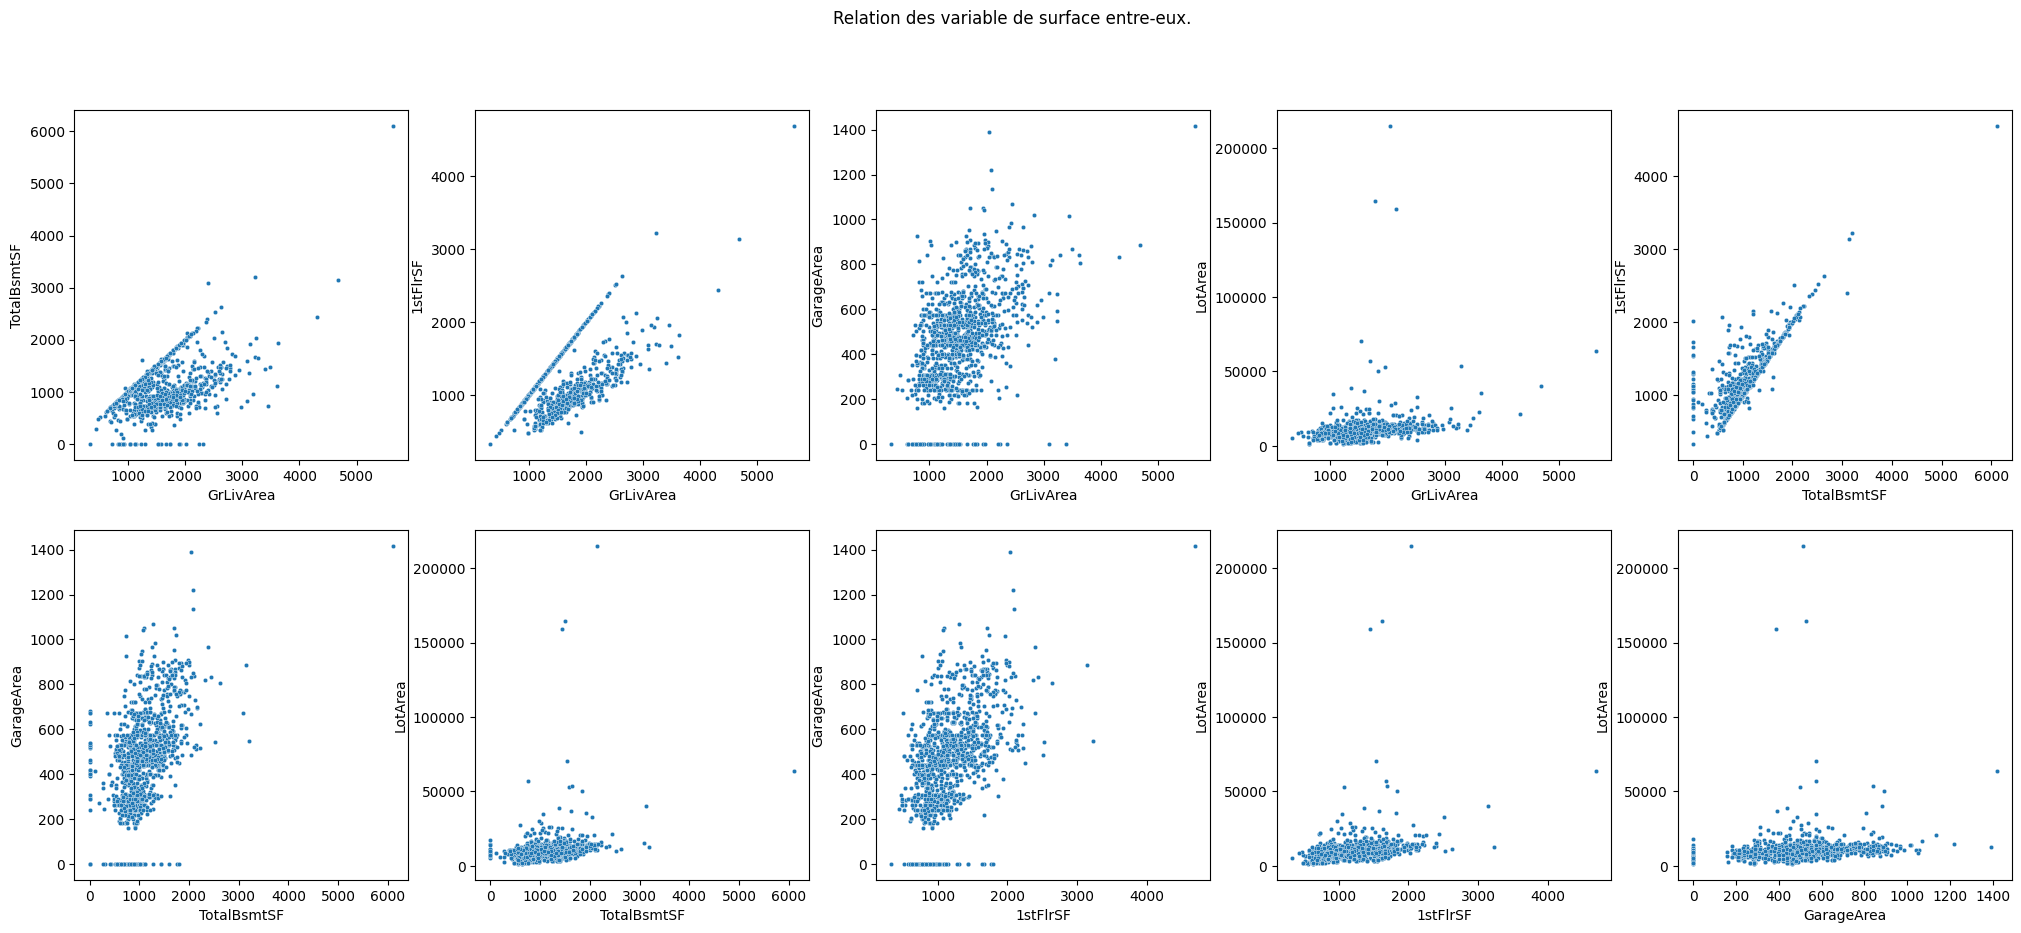

In [202]:
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(25, 10)
plt.suptitle("Relation des variable de surface entre-eux.")
sns.scatterplot(data=train_set, x="GrLivArea", y="TotalBsmtSF", s=10, ax=ax[0, 0])
sns.scatterplot(data=train_set, x="GrLivArea", y="1stFlrSF", s=10, ax=ax[0, 1])
sns.scatterplot(data=train_set, x="GrLivArea", y="GarageArea", s=10, ax=ax[0, 2])
sns.scatterplot(data=train_set, x="GrLivArea", y="LotArea", s=10, ax=ax[0, 3])
sns.scatterplot(data=train_set, x="TotalBsmtSF", y="1stFlrSF", s=10, ax=ax[0, 4])
sns.scatterplot(data=train_set, x="TotalBsmtSF", y="GarageArea", s=10, ax=ax[1, 0])
sns.scatterplot(data=train_set, x="TotalBsmtSF", y="LotArea", s=10, ax=ax[1, 1])
sns.scatterplot(data=train_set, x="1stFlrSF", y="GarageArea", s=10, ax=ax[1, 2])
sns.scatterplot(data=train_set, x="1stFlrSF", y="LotArea", s=10, ax=ax[1, 3])
sns.scatterplot(data=train_set, x="GarageArea", y="LotArea", s=10, ax=ax[1, 4])
plt.show()

On voit qu'il y a pour la superficie totale du sous-sol, la surface habitable hors sous-sol, la superfice du rez-de-chaussée et pour la taille du garage des relations assez forte visuellement. Par contre toutes les variables ne sont pas trop corrélée à la surface totale du terrain. Certaines maisons ont leurs surface habitable hors sous-sol identiques à leurs superficie du rez-de-chaussée. D'autres maisons ont leurs superficie du rez-de-chaussée identiques à leurs superficie totale du sous-sol. Il y a aussi des maisons qui ont leurs surface habitable hors sous-sol identique à leurs superficie totale du sous-sol. Il y a donc peut-être une relation assez forte entre ces trois variables de surfaces. On peut peut-être créer des groupes qui décrivent un type de maison particulier pour chaque situations décrit précédemment. On voit qu'il y a deux relations linéaire différentes pour la relation entre la surface habitable hors sous-sol et la superficie du rez-de-chaussée. Il y a donc présence de deux types de maison distinct. On voit à peu prés la même chose pour la relation entre la surface habitable hors sous-sol et la superficie totale du sous-sol mais moins prononcé. On va donc commencer par les groupes qu'on peut former avec la relation entre la surface habitable hors sous-sol et la superficie du rez-de-chaussée. On va donc visualiser sur une surface 3D la surface habitable hors sous-sol, la superficie totale du sous-sol et du rez de chaussée.

In [203]:
fig = px.scatter_3d(train_set, x="GrLivArea", y="1stFlrSF", z="TotalBsmtSF")
fig.update_traces(marker_size=2)
fig.update_layout(
    title="Relation entre la surface habitable hors sous-sol, la superficie totale du sous-sol et la superficie du rez-de-chaussée.",
    title_x=0.5,
    title_y=0.96,
)
fig.show()

On voit clairement deux groupes, celle visualiser sur la relation entre la surface habitable hors sous-sol et la superficie du rez-de-chaussée. On va donc créer cette variable de groupe. LA valeur 1 sera dans le cas d'égalité des deux surface et 0 pour le cas dans lequel les deux surface sont différentes.

In [204]:
analyse_set = train_set.copy()

condition_list = [analyse_set["GrLivArea"] == analyse_set["1stFlrSF"]]

choice_list = [1]

analyse_set["GroupSurface"] = np.select(condition_list, choice_list, default=0)
analyse_set["GroupSurface"].value_counts()

GroupSurface
1    671
0    509
Name: count, dtype: int64

On voit qu'il y a plus de 30 maisons par groupe. 

In [205]:
analyse_set.groupby("GroupSurface")["SalePrice"].describe()

,count,mean,std,min,25%,50%,75%,max
GroupSurface,,,,,,,,
0,509.0,191202.387033,83949.915185,37900.0,135000.0,175500.0,228000.0,755000.0
1,671.0,171189.485842,75247.281592,34900.0,125000.0,150750.0,195700.0,611657.0


On voit que les maisons qui ont les deux surfaces identiques sont en moyennes moins cher que ceux qui ont leurs surface habitables hors sous-sol plus grand que le rez-de-chaussée. Pour valider cette observation, on va faire un test de student. Voici les conditions d'utilisation:

1) La forme ou la structure d'une maison ne dépends pas des autres.

2) Toutes les maisons sont issues d'Ames en Iowa et aussi dans les alentours.

3) Il y a bien plus de 30 points par classes.

4) Les écart-types sont assez similaires pour faire un test de student.

In [206]:
print(
    """H0: Les maisons qui ont leurs surface habitable 
    hors sous-sol identiques à leurs superficie du rez-de-chaussée 
    ont en moyenne le même prix que ceux dont leurs surface habitable 
    hors sous-sol sont supérieur à leurs superficie du rez-de-chaussée."""
)

alpha = 0.02

p_value = ttest_ind(
    analyse_set.query("`GroupSurface` == 1")["SalePrice"],
    analyse_set.query("`GroupSurface` == 0")["SalePrice"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les maisons qui ont leurs surface habitable 
    hors sous-sol identiques à leurs superficie du rez-de-chaussée 
    ont en moyenne le même prix que ceux dont leurs surface habitable 
    hors sous-sol sont supérieur à leurs superficie du rez-de-chaussée.
Nous avons assez d'évidence pour rejeter H0.


Comme l'hypothése H0 à été rejeter, on peut dire que les deux groupes ont en moyenne des prix différents. Regardons maintenant les relations surface-prix avec les deux groupes.

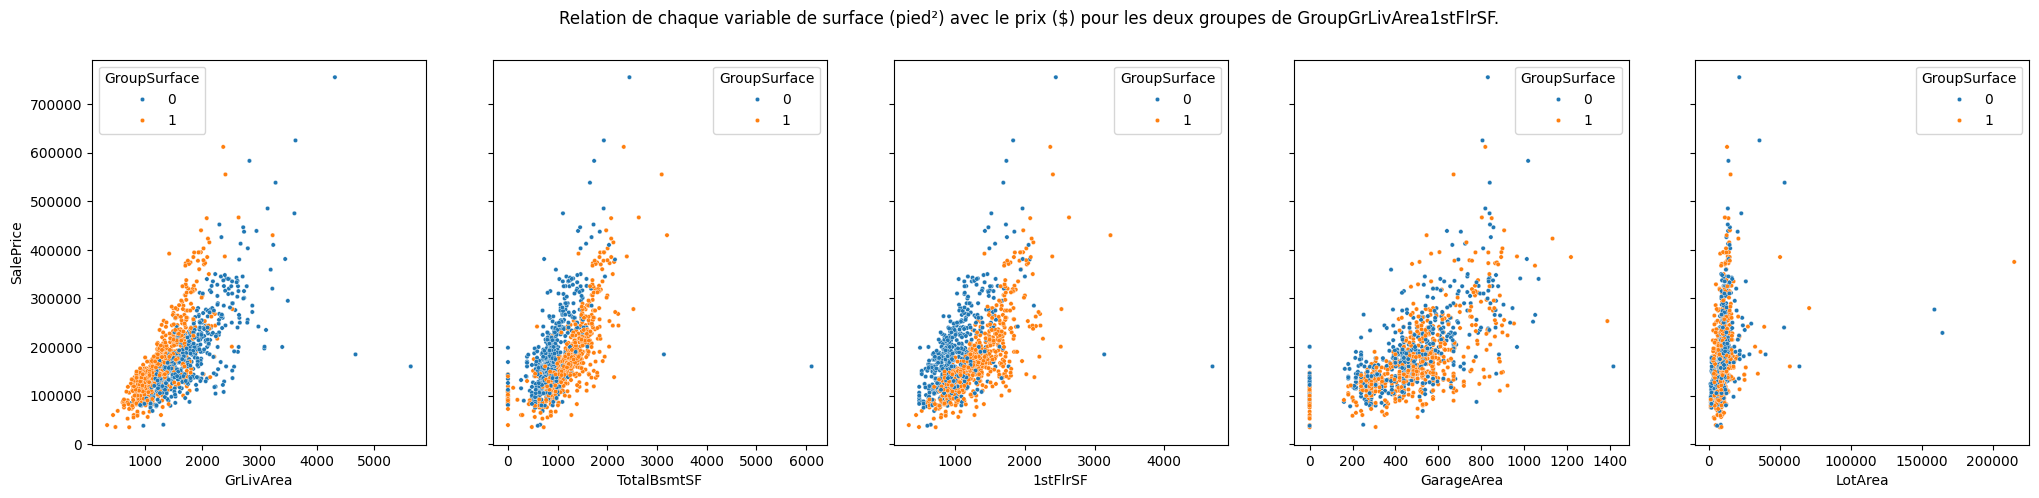

In [207]:
fig, ax = plt.subplots(1, 5, sharey=True)
fig.set_size_inches(25, 5)
plt.suptitle(
    "Relation de chaque variable de surface (pied²) avec le prix ($) pour les deux groupes de GroupGrLivArea1stFlrSF."
)
sns.scatterplot(
    data=analyse_set,
    x="GrLivArea",
    y="SalePrice",
    hue="GroupSurface",
    ax=ax[0],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="TotalBsmtSF",
    y="SalePrice",
    hue="GroupSurface",
    ax=ax[1],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="1stFlrSF",
    y="SalePrice",
    hue="GroupSurface",
    ax=ax[2],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="GarageArea",
    y="SalePrice",
    hue="GroupSurface",
    ax=ax[3],
    s=10,
)
sns.scatterplot(
    data=analyse_set, x="LotArea", y="SalePrice", hue="GroupSurface", ax=ax[4], s=10
)
plt.show()

On remarque que sur les trois premiére relation les deux groupes ne sont pas superposée. On a aussi le groupe des deux surface égaux qui est à gauche pour la premiére relation et à droite pour mes deux suivantes. Pour les deux derniéres relation, les deux groupes sont superposés. On va donc diviser le probléme en deux sous problémes. Comme on divise le probléme en sous-groupe, on peut peu-être de trouver d'autres groupe à partir des variables de temps et de la variable de voisinage.

## II.3) Analyse des variables de temps

### II.3.1) Analyse univarié

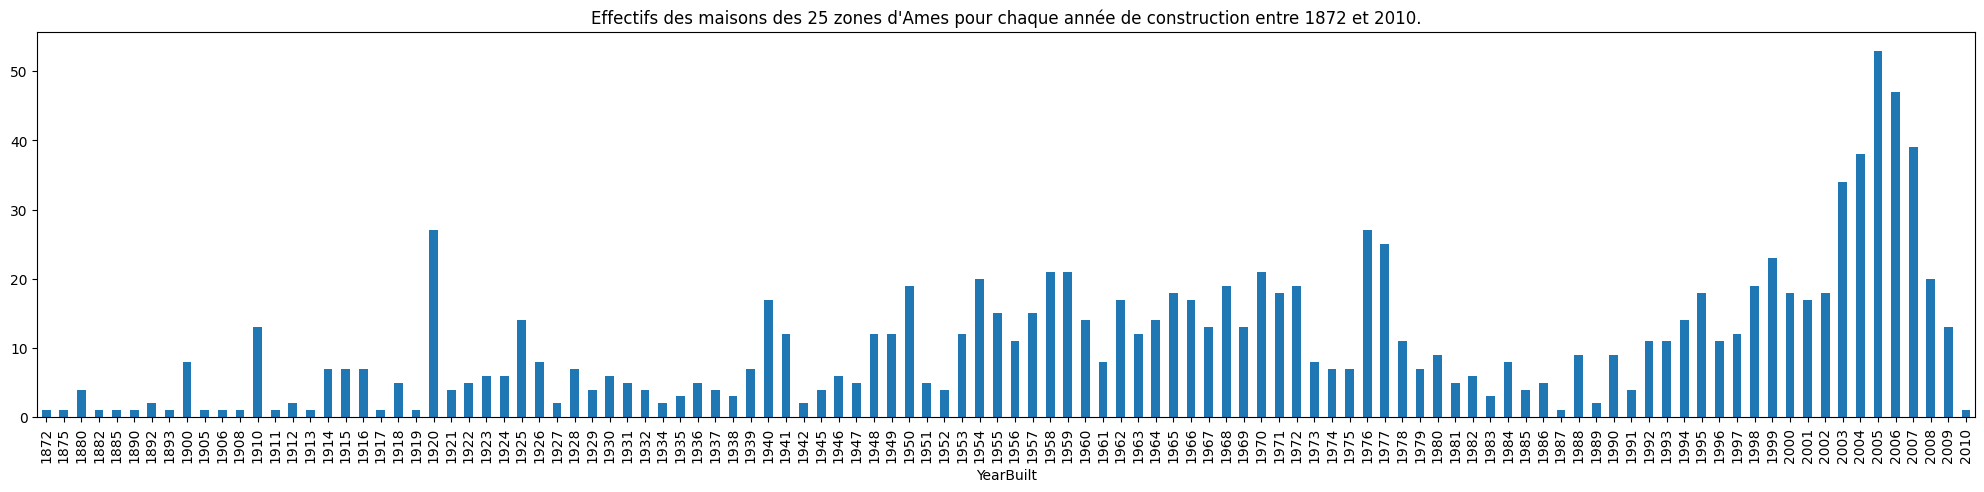

In [208]:
fig = plt.figure(figsize=(25, 5))
analyse_set["YearBuilt"].value_counts().sort_index().plot(kind="bar")
plt.title(
    "Effectifs des maisons des 25 zones d'Ames pour chaque année de construction entre 1872 et 2010."
)
plt.show()

On voit qu'il y a peu de maisons construite avant 1900 puis aprés le nombres est relativement constant entre 1900 et 1977. On a ensuite une diminution suivie de la plus grande augmentation dans les années 2000.

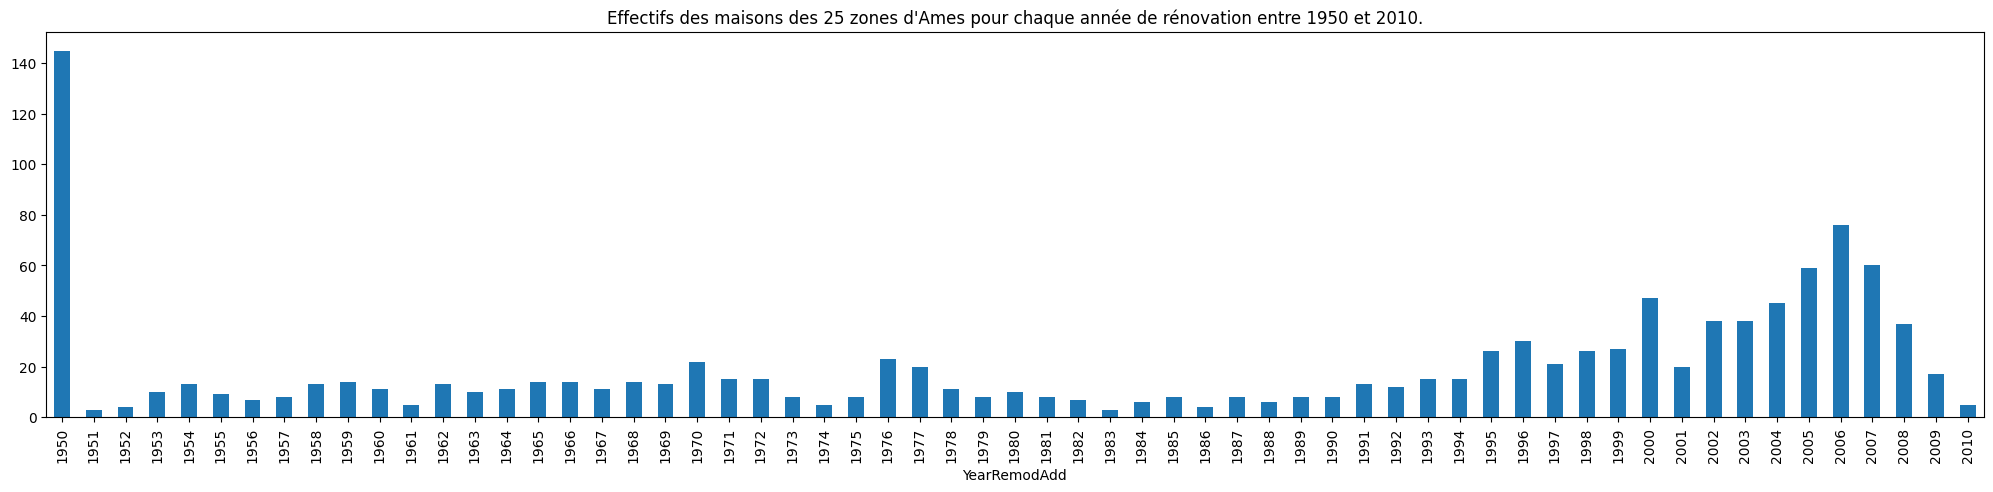

In [209]:
fig = plt.figure(figsize=(25, 5))
analyse_set["YearRemodAdd"].value_counts().sort_index().plot(kind="bar")
plt.title(
    "Effectifs des maisons des 25 zones d'Ames pour chaque année de rénovation entre 1950 et 2010."
)
plt.show()

On voit que la plupart des maisons ont été rénover en 1950 puis aprés c'est relativement constant et vers les années 2000 on a une légére augmentation et diminution. Maintenant passon à l'analyse multivarié.

### II.3.2) Analyse multivarié

#### II.3.2.1) Analyse des deux variables de temps en fonction du prix.

Premiérement on peut analyser l'évolution de la moyenne de prix en fonction de chaque variable de temps. Comme il manque certaine années, on va utiliser un scatterplot.

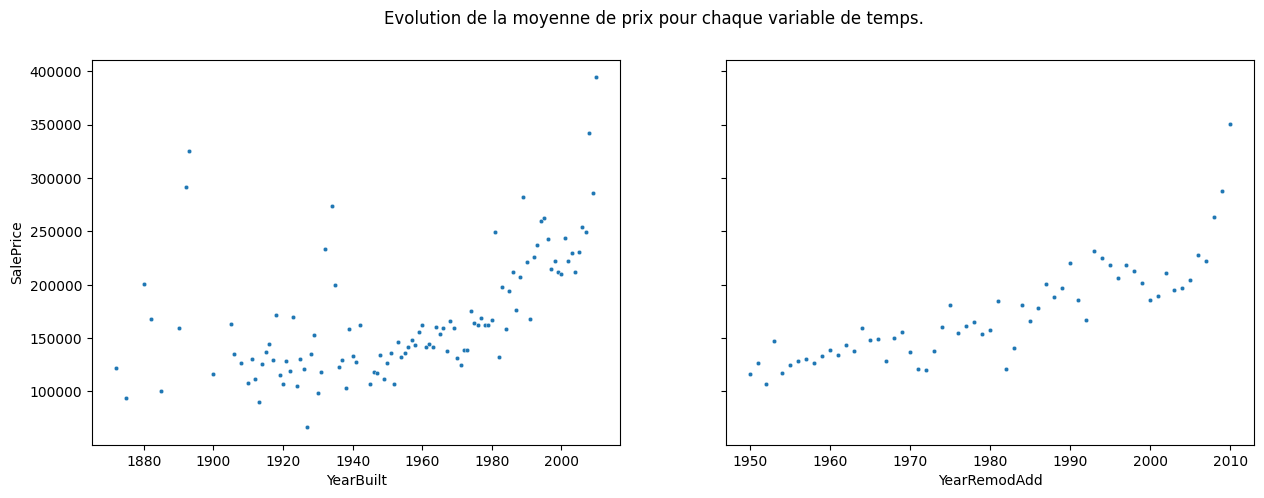

In [210]:
data1 = analyse_set.groupby(["YearBuilt"])["SalePrice"].mean().reset_index()
data2 = analyse_set.groupby(["YearRemodAdd"])["SalePrice"].mean().reset_index()
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(15, 5)
plt.suptitle("Evolution de la moyenne de prix pour chaque variable de temps.")
sns.scatterplot(data=data1, x="YearBuilt", y="SalePrice", ax=ax[0], s=10)
sns.scatterplot(
    data=data2,
    x="YearRemodAdd",
    y="SalePrice",
    ax=ax[1],
    s=10,
)
plt.show()

On voit clairement une augmentation de la moyenne de prix en fonction des variables de temps. Pour tester de maniére clair cette relation, on va créer deux moitié.

In [211]:
analyse_set.query("`YearBuilt` <= 1941")["SalePrice"].describe()

count       219.000000
mean     133522.858447
std       59029.931927
min       34900.000000
25%      100000.000000
50%      120000.000000
75%      151287.500000
max      475000.000000
Name: SalePrice, dtype: float64

In [212]:
analyse_set.query("`YearBuilt` > 1941")["SalePrice"].describe()

count       961.000000
mean     190373.209157
std       80062.982126
min       35311.000000
25%      137500.000000
50%      173000.000000
75%      224000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [213]:
analyse_set.query("`YearRemodAdd` <= 1980")["SalePrice"].describe()

count       487.000000
mean     134720.954825
std       40984.062840
min       34900.000000
25%      109900.000000
50%      132500.000000
75%      155000.000000
max      375000.000000
Name: SalePrice, dtype: float64

In [214]:
analyse_set.query("`YearRemodAdd` > 1980")["SalePrice"].describe()

count       693.000000
mean     211516.673882
std       84888.982175
min       64500.000000
25%      155000.000000
50%      191000.000000
75%      248000.000000
max      755000.000000
Name: SalePrice, dtype: float64

On voit que pour les deux variables de temps, il y a bien une augmentation du prix en fonction du temps. On a des écert-types assez simialires pour l'année de construction pour utiliser un test de student mais ce n'est pas le cas pour l'années de rénovation.

In [215]:
print(
    """H0: Les maisons qui sont dans la premiére moitié d'année de construction ont en moyenne le même prix ."""
)

alpha = 0.02

p_value = ttest_ind(
    analyse_set.query("`YearBuilt` <= 1941")["SalePrice"],
    analyse_set.query("`YearBuilt` > 1941")["SalePrice"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les maisons qui sont dans la premiére moitié d'année de construction ont en moyenne le même prix .
Nous avons assez d'évidence pour rejeter H0.


In [216]:
print(
    """H0: Les maisons qui sont dans la premiére moitié d'année de rénovation ont en moyenne le même prix ."""
)

alpha = 0.02

p_value = ttest_ind(
    analyse_set.query("`YearBuilt` <= 1941")["SalePrice"],
    analyse_set.query("`YearBuilt` > 1941")["SalePrice"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les maisons qui sont dans la premiére moitié d'année de rénovation ont en moyenne le même prix .
Nous avons assez d'évidence pour rejeter H0.


Comme les hypothéses H0 ont été rejeté, on peut dire qu'il y a bien une augmentatio du prix moyen pour les deu variables de temps. Comme il y a beaucoup d'années, on peut essayer de regarder les deux relations sur une surface scatter et de calculer la corrélation de spearman.

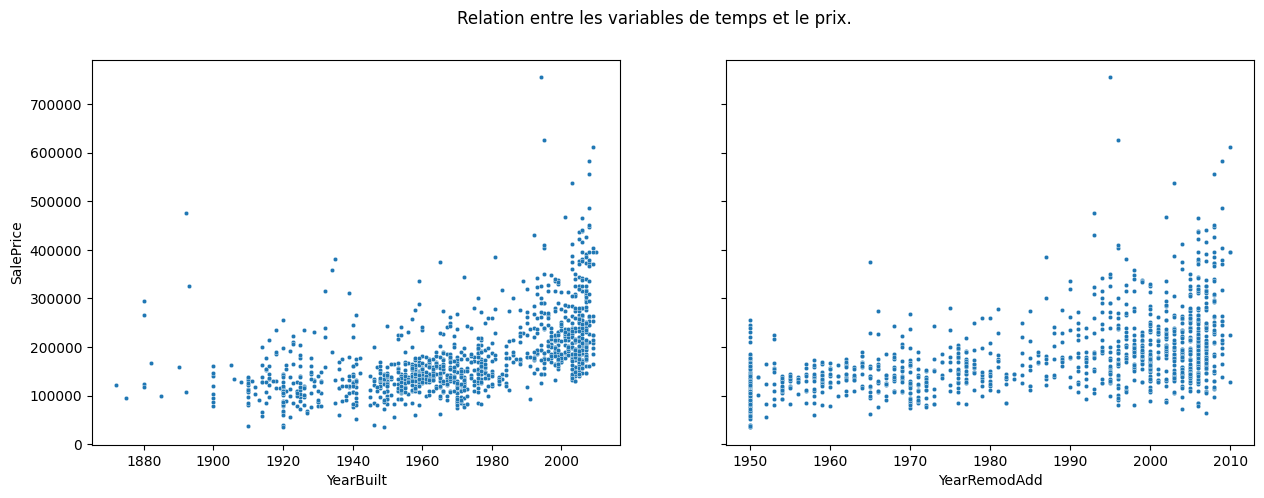

SignificanceResult(statistic=np.float64(0.6546421052259204), pvalue=np.float64(2.553581667723839e-145))
SignificanceResult(statistic=np.float64(0.5698087798014284), pvalue=np.float64(1.5494246830527667e-102))


In [217]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(15, 5)
plt.suptitle("Relation entre les variables de temps et le prix.")
sns.scatterplot(data=analyse_set, x="YearBuilt", y="SalePrice", ax=ax[0], s=10)
sns.scatterplot(
    data=analyse_set,
    x="YearRemodAdd",
    y="SalePrice",
    ax=ax[1],
    s=10,
)
plt.show()
print(spearmanr(analyse_set["YearBuilt"], analyse_set["SalePrice"]))
print(spearmanr(analyse_set["YearRemodAdd"], analyse_set["SalePrice"]))

On voit qu'il y a une relation entre l'année de construction et le prix mais pour la relation entre l'année de rénovation et le prix, on voit une relation linéaire mais avec une légére pente. Pour le cas de l'année de construction, les deux groupes sont comme légéremment décalés mais pour la date de rénovation, les deux groupes sont superposées même si on observe une zone entre 1990 et 2000 dans lequel on ne voit pas beaucoup de maisons ayant les deux surfaces identiques. On voit qu'il y a une présence de forte corrélation entre chaque variable de temps et le prix. Regardons maintenant la relation entre les deux variables de temps.

#### II.3.2.2) Analyse des variables de temps entre-eux.

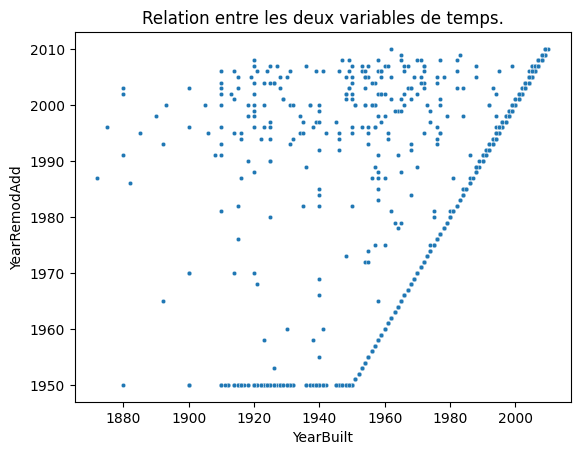

In [218]:
sns.scatterplot(data=analyse_set, x="YearBuilt", y="YearRemodAdd", s=10)
plt.title("Relation entre les deux variables de temps.")
plt.show()

On voit qu'on peut créer encore deux groupes car on voit des points qui se suit et un nuage de points. On va donc faire les deux groupes.

In [219]:
condition_list = [
    (
        (analyse_set["YearBuilt"] == analyse_set["YearRemodAdd"])
        | (analyse_set["YearBuilt"] == analyse_set["YearRemodAdd"] - 1)
        | (analyse_set["YearBuilt"] == analyse_set["YearRemodAdd"] - 2)
    )
    | (
        (analyse_set["YearBuilt"] != analyse_set["YearRemodAdd"])
        & (analyse_set["YearRemodAdd"] == 1950)
    ),
]

choice_list = [1]

analyse_set["GroupYear"] = np.select(
    condlist=condition_list, choicelist=choice_list, default=0
)
analyse_set["GroupYear"].value_counts()

GroupYear
1    917
0    263
Name: count, dtype: int64

On voit qu'il y a bien plus de 30 points par classe. On va maintenant regarder chaque nouveau groupe sur les relations précédentes. Pour les trois groupes on va d'abords regarder les staistiques puis faire un test de ANOVA.

In [220]:
analyse_set.groupby("GroupYear")["SalePrice"].describe()

,count,mean,std,min,25%,50%,75%,max
GroupYear,,,,,,,,
0,263.0,160637.707224,60678.758198,64500.0,125587.5,145500.0,179950.0,475000.0
1,917.0,185324.365322,83591.105654,34900.0,130000.0,170000.0,220000.0,755000.0


On observe que les moyennes de prix entre les trois groupes sont relativement différents. On voit que les écart-type sont assez similaire pour faire un test de student.

In [221]:
print("Les maisons des deux groupes d'années ont en moyenne le même prix.")

alpha = 0.02

p_value = ttest_ind(
    analyse_set.query("`GroupYear` == 0")["SalePrice"],
    analyse_set.query("`GroupYear` == 1")["SalePrice"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

Les maisons des deux groupes d'années ont en moyenne le même prix.
Nous avons assez d'évidence pour rejeter H0.


Comme on a rejter H0, on peut dire avec un seuil alpha de 2% que les maisons des deux groupes d'années ont en moyenne des prix différents. Pour les deux relations avec les variables de temps, on va visualiser l'évolution de la moyenne de prix pour les trois groupes.

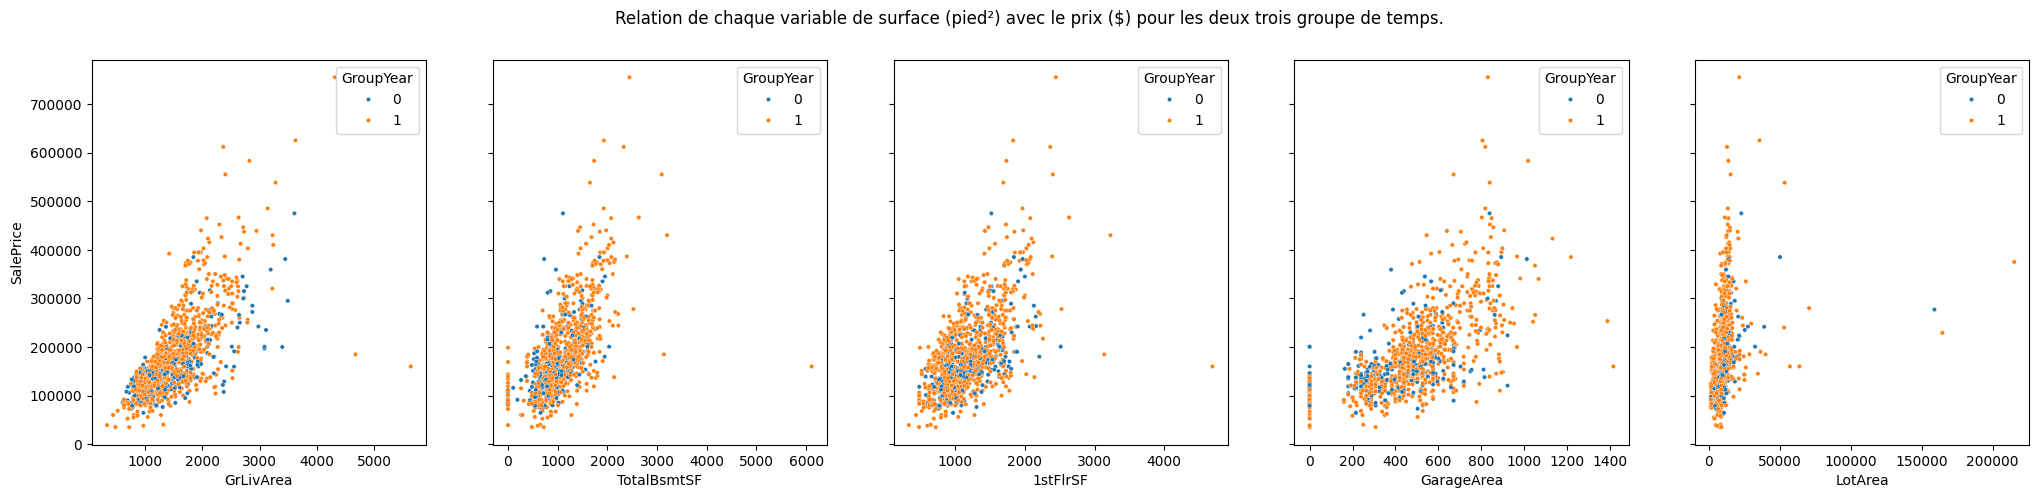

In [222]:
fig, ax = plt.subplots(1, 5, sharey=True)
fig.set_size_inches(25, 5)
plt.suptitle(
    "Relation de chaque variable de surface (pied²) avec le prix ($) pour les deux trois groupe de temps."
)
sns.scatterplot(
    data=analyse_set,
    x="GrLivArea",
    y="SalePrice",
    hue="GroupYear",
    ax=ax[0],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="TotalBsmtSF",
    y="SalePrice",
    hue="GroupYear",
    ax=ax[1],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="1stFlrSF",
    y="SalePrice",
    hue="GroupYear",
    ax=ax[2],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="GarageArea",
    y="SalePrice",
    hue="GroupYear",
    ax=ax[3],
    s=10,
)
sns.scatterplot(
    data=analyse_set, x="LotArea", y="SalePrice", hue="GroupYear", ax=ax[4], s=10
)
plt.show()

On voit que les deux groupes sont superposés pour toutes les relations. Regardons avec les variables de temps.

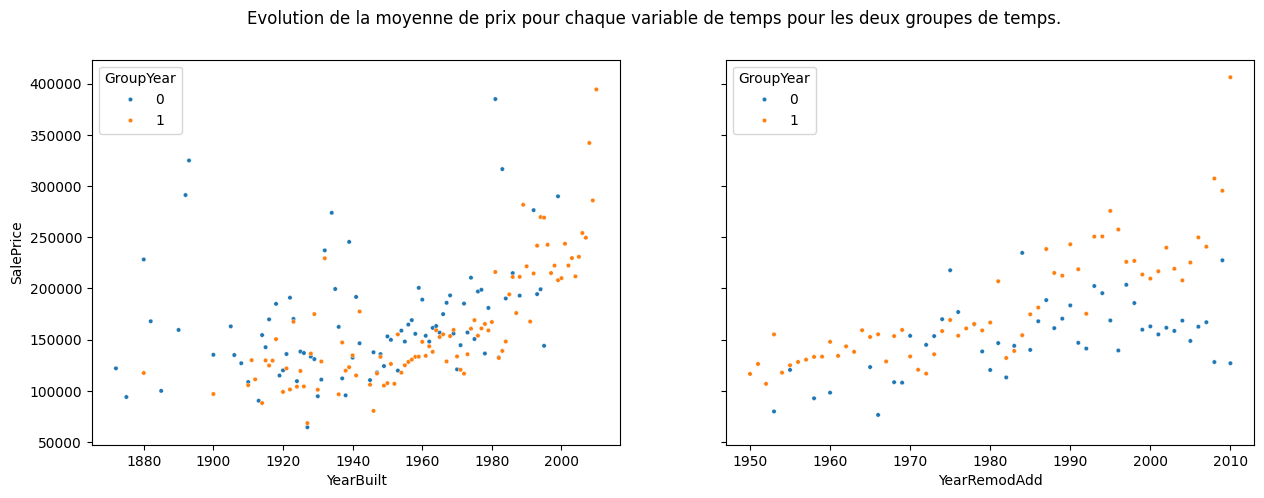

In [223]:
data1 = (
    analyse_set.groupby(["GroupYear", "YearBuilt"])["SalePrice"].mean().reset_index()
)
data2 = (
    analyse_set.groupby(["GroupYear", "YearRemodAdd"])["SalePrice"].mean().reset_index()
)
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(15, 5)
plt.suptitle(
    "Evolution de la moyenne de prix pour chaque variable de temps pour les deux groupes de temps."
)
sns.scatterplot(
    data=data1, x="YearBuilt", y="SalePrice", hue="GroupYear", ax=ax[0], s=10
)
sns.scatterplot(
    data=data2,
    x="YearRemodAdd",
    y="SalePrice",
    hue="GroupYear",
    ax=ax[1],
    s=10,
)
plt.show()

On voit que les deux groupes se superpose mais on voit que le groupe 1 à la prix moyen qui augmente légérement plus que le groupe 0. On va maintenant regarder la relation entre les deux variables de groupes.

In [224]:
pd.crosstab(analyse_set["GroupSurface"], analyse_set["GroupYear"])

GroupYear,0,1
GroupSurface,,
0,125,384
1,138,533


On voit qu'on a bien plus de 30 maisons par groupes. On va maintenant combiner les deux variables.

In [225]:
analyse_set["GrouHouse"] = analyse_set["GroupSurface"].astype(str) + analyse_set[
    "GroupYear"
].astype(str)
analyse_set["GrouHouse"].value_counts()

GrouHouse
11    533
01    384
10    138
00    125
Name: count, dtype: int64

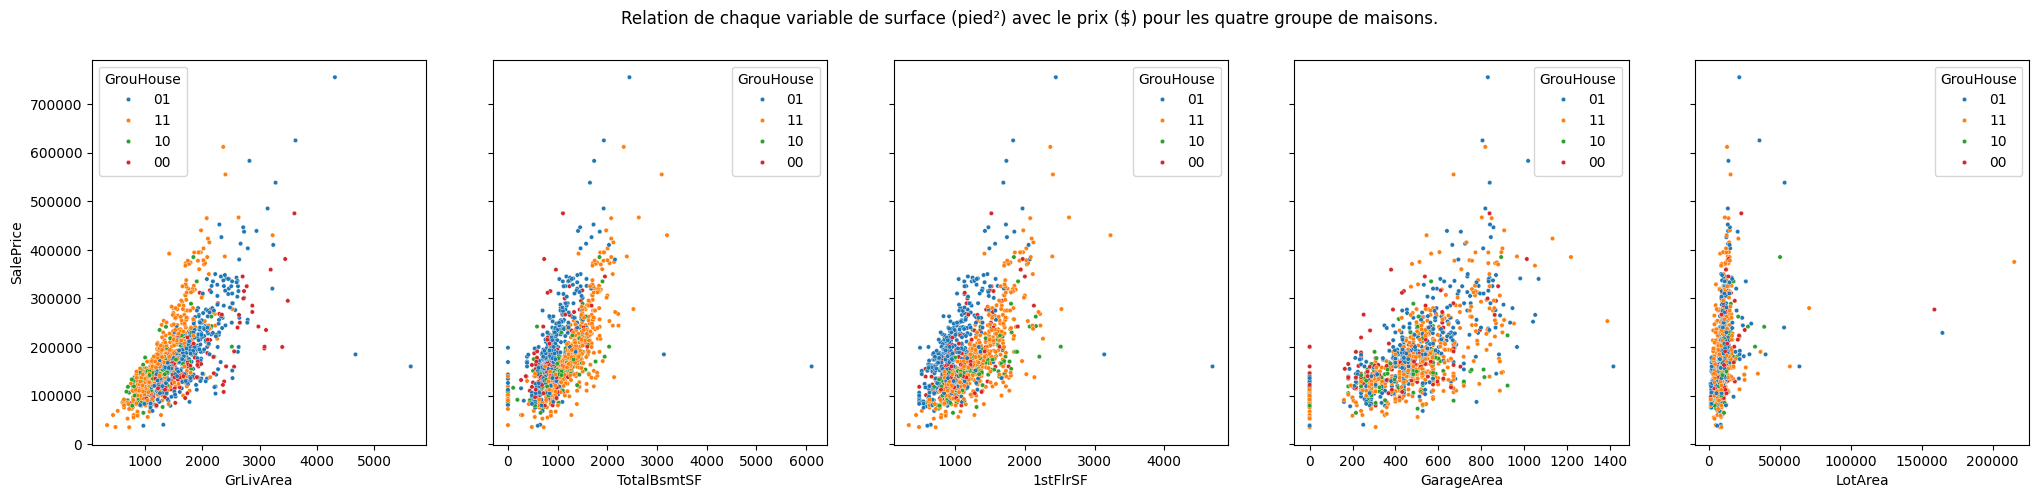

In [226]:
fig, ax = plt.subplots(1, 5, sharey=True)
fig.set_size_inches(25, 5)
plt.suptitle(
    "Relation de chaque variable de surface (pied²) avec le prix ($) pour les quatre groupe de maisons."
)
sns.scatterplot(
    data=analyse_set,
    x="GrLivArea",
    y="SalePrice",
    hue="GrouHouse",
    ax=ax[0],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="TotalBsmtSF",
    y="SalePrice",
    hue="GrouHouse",
    ax=ax[1],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="1stFlrSF",
    y="SalePrice",
    hue="GrouHouse",
    ax=ax[2],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="GarageArea",
    y="SalePrice",
    hue="GrouHouse",
    ax=ax[3],
    s=10,
)
sns.scatterplot(
    data=analyse_set, x="LotArea", y="SalePrice", hue="GrouHouse", ax=ax[4], s=10
)
plt.show()

Comparons maintenant les statistiques de prix pour chaque groupes.

In [227]:
analyse_set.groupby("GrouHouse")["SalePrice"].describe()

,count,mean,std,min,25%,50%,75%,max
GrouHouse,,,,,,,,
00,125.0,172678.336000,69860.198240,79500.0,127500.0,155000.0,200000.0,475000.0
01,384.0,197232.351562,87287.891235,37900.0,139375.0,180500.0,231875.0,755000.0
10,138.0,149731.340580,48702.011216,64500.0,120125.0,144000.0,167750.0,385000.0
11,533.0,176745.253283,79810.632943,34900.0,126500.0,157000.0,207500.0,611657.0


Le groupe 00 à une moyenne similaire au groupe 11. On va d'abords faire un test de student sur ces deux groupes.

In [228]:
print(
    "H0: Les maisons dans le groupe 00 ont en moyenne le même prix que les maisons du groupe 11."
)

alpah = 0.02

p_value = ttest_ind(
    analyse_set.query("`GrouHouse` == '00'")["SalePrice"],
    analyse_set.query("`GrouHouse` == '11'")["SalePrice"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les maisons dans le groupe 00 ont en moyenne le même prix que les maisons du groupe 11.
Nous n'avons pas assez d'évidence pour rejeter H0.


On voit que les deux groupes tester ont en moyenne le même prix et donc on va les combiner. On va aussi remplacer chaque valeur par 0, 1 et 2.

In [229]:
analyse_set["GrouHouse"].replace({"00": 0, "11": 0, "01": 1, "10": 2}, inplace=True)
analyse_set.groupby("GrouHouse")["SalePrice"].describe()

/tmp/ipykernel_13645/3990681541.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_13645/3990681541.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,count,mean,std,min,25%,50%,75%,max
GrouHouse,,,,,,,,
0,658.0,175972.662614,77984.019923,34900.0,127000.0,157000.0,205000.0,611657.0
1,384.0,197232.351562,87287.891235,37900.0,139375.0,180500.0,231875.0,755000.0
2,138.0,149731.340580,48702.011216,64500.0,120125.0,144000.0,167750.0,385000.0


Les trois groupes ont cette fois-ci des moyennes différentes. On va faire un test de ANOVA.

In [234]:
print("H0: Les maisons des 4 groupes ont en moyenne le même prix.")

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("GrouHouse")["SalePrice"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les maisons des 4 groupes ont en moyenne le même prix.
Nous avons assez d'évidence pour rejeter H0.


Comme l'hypothése H0 à été rejeter, on peut donc dire que les trois groupes de maisons ont des statistiques de prix différents. On peut donc diviser le probléme en trois groupe. Regardons maintenant les trois groupes sur les relations.

## II.4) Analyse des variables de surfaces pour les trois groupes.

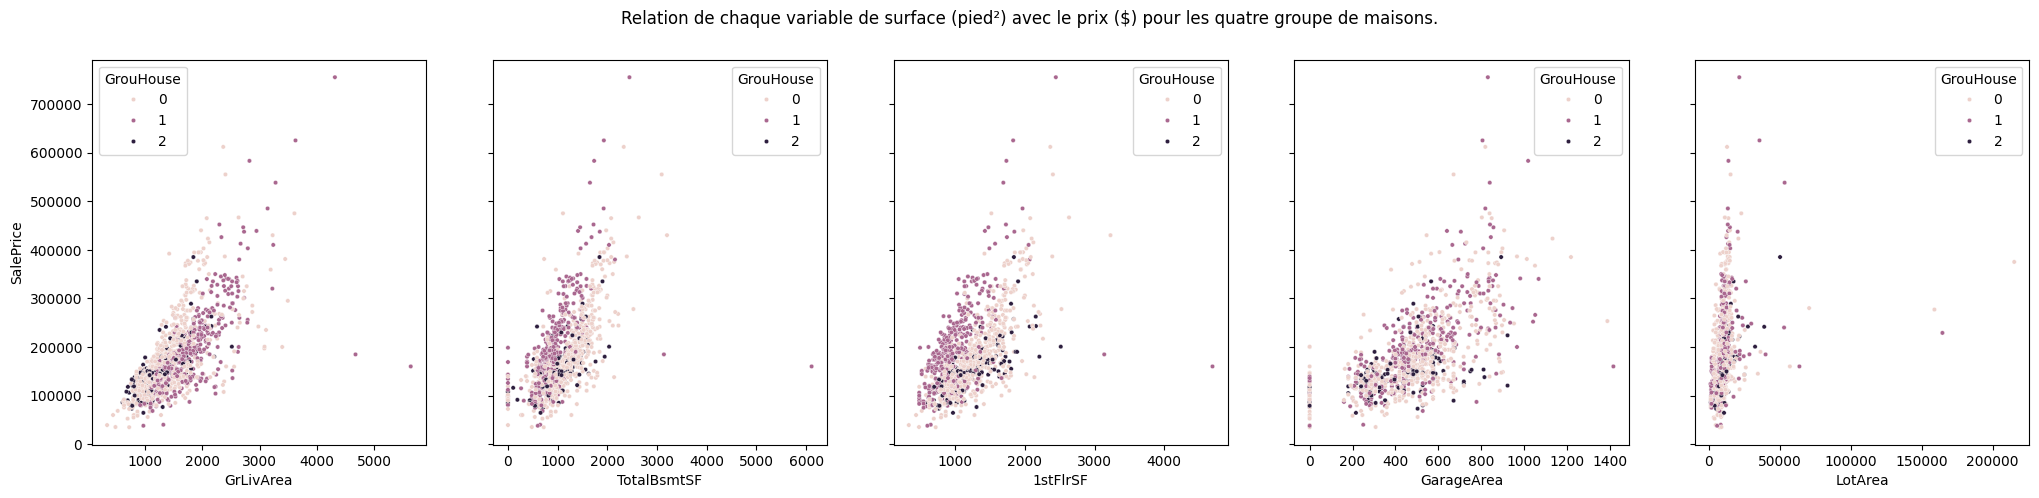

In [235]:
fig, ax = plt.subplots(1, 5, sharey=True)
fig.set_size_inches(25, 5)
plt.suptitle(
    "Relation de chaque variable de surface (pied²) avec le prix ($) pour les quatre groupe de maisons."
)
sns.scatterplot(
    data=analyse_set,
    x="GrLivArea",
    y="SalePrice",
    hue="GrouHouse",
    ax=ax[0],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="TotalBsmtSF",
    y="SalePrice",
    hue="GrouHouse",
    ax=ax[1],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="1stFlrSF",
    y="SalePrice",
    hue="GrouHouse",
    ax=ax[2],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="GarageArea",
    y="SalePrice",
    hue="GrouHouse",
    ax=ax[3],
    s=10,
)
sns.scatterplot(
    data=analyse_set, x="LotArea", y="SalePrice", hue="GrouHouse", ax=ax[4], s=10
)
plt.show()

On remarque que les deux groupes principaux ce sont mélangés un peu plus et que le troisiéme groupes est complêtement superposé au deux autres groupes. On va donc décomposé le probléme en trois groupes. 

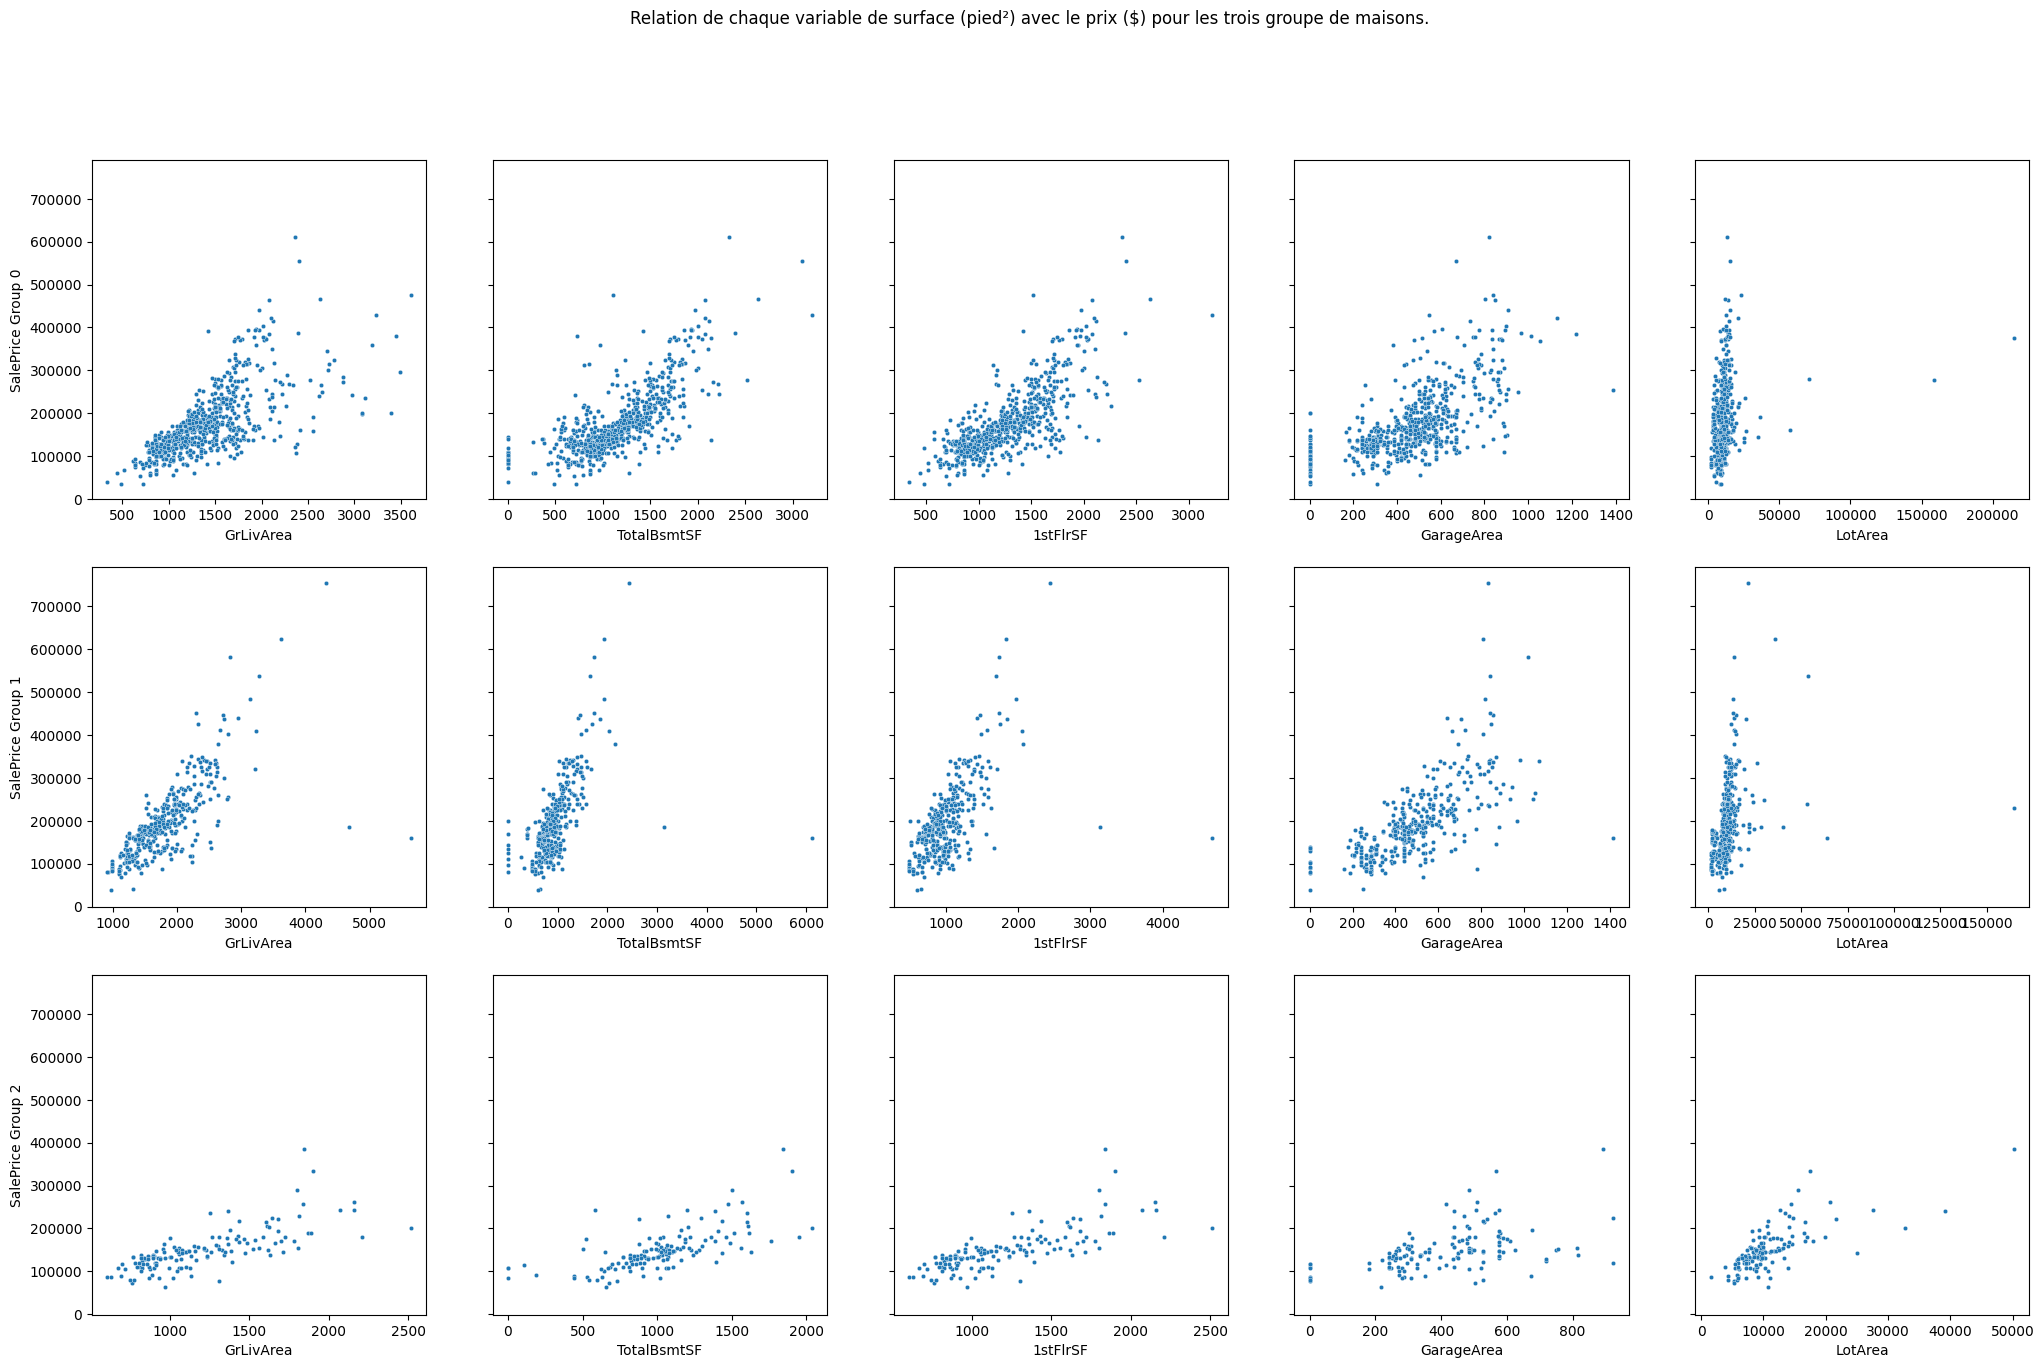

In [238]:
analyse_set_0 = analyse_set.query("`GrouHouse` == 0")
analyse_set_1 = analyse_set.query("`GrouHouse` == 1")
analyse_set_2 = analyse_set.query("`GrouHouse` == 2")
fig, ax = plt.subplots(3, 5, sharey=True)
fig.set_size_inches(25, 15)
ax[0, 0].set_ylabel("SalePrice Group 0")
ax[1, 0].set_ylabel("SalePrice Group 1")
ax[2, 0].set_ylabel("SalePrice Group 2")
plt.suptitle(
    "Relation de chaque variable de surface (pied²) avec le prix ($) pour les trois groupe de maisons."
)
sns.scatterplot(
    data=analyse_set_0,
    x="GrLivArea",
    y="SalePrice",
    ax=ax[0, 0],
    s=10,
)
sns.scatterplot(
    data=analyse_set_0,
    x="TotalBsmtSF",
    y="SalePrice",
    ax=ax[0, 1],
    s=10,
)
sns.scatterplot(
    data=analyse_set_0,
    x="1stFlrSF",
    y="SalePrice",
    ax=ax[0, 2],
    s=10,
)
sns.scatterplot(
    data=analyse_set_0,
    x="GarageArea",
    y="SalePrice",
    ax=ax[0, 3],
    s=10,
)
sns.scatterplot(data=analyse_set_0, x="LotArea", y="SalePrice", ax=ax[0, 4], s=10)
sns.scatterplot(
    data=analyse_set_1,
    x="GrLivArea",
    y="SalePrice",
    ax=ax[1, 0],
    s=10,
)
sns.scatterplot(
    data=analyse_set_1,
    x="TotalBsmtSF",
    y="SalePrice",
    ax=ax[1, 1],
    s=10,
)
sns.scatterplot(
    data=analyse_set_1,
    x="1stFlrSF",
    y="SalePrice",
    ax=ax[1, 2],
    s=10,
)
sns.scatterplot(
    data=analyse_set_1,
    x="GarageArea",
    y="SalePrice",
    ax=ax[1, 3],
    s=10,
)
sns.scatterplot(data=analyse_set_1, x="LotArea", y="SalePrice", ax=ax[1, 4], s=10)
sns.scatterplot(
    data=analyse_set_2,
    x="GrLivArea",
    y="SalePrice",
    ax=ax[2, 0],
    s=10,
)
sns.scatterplot(
    data=analyse_set_2,
    x="TotalBsmtSF",
    y="SalePrice",
    ax=ax[2, 1],
    s=10,
)
sns.scatterplot(
    data=analyse_set_2,
    x="1stFlrSF",
    y="SalePrice",
    ax=ax[2, 2],
    s=10,
)
sns.scatterplot(
    data=analyse_set_2,
    x="GarageArea",
    y="SalePrice",
    ax=ax[2, 3],
    s=10,
)
sns.scatterplot(data=analyse_set_2, x="LotArea", y="SalePrice", ax=ax[2, 4], s=10)
plt.show()

On voit que pour le groupe 0, on voit que les relation 2 et 3 sont trés similaires et qu'ils sont seulement différents à cause de quelsues maisons qui n'ont pas de sous-sol. Pour le groupe 2, on a les relations 1 et 3 qui sont identiques. Dans tous les cas les quatre premiére relations nous montre qu'il y a une corrélation. Pour la derniére surface, c'est beaucoup plus diffcile de dire si il y a une relation. On va donc calculer les corrélations de pearson.

In [ ]:
print(
    "Surface habitable hors sous-sol-prix groupe 0:",
    pearsonr(analyse_set_0["GrLivArea"], analyse_set_0["SalePrice"]),
)
print(
    "Superficie totale du sous-sol-prix 0:",
    pearsonr(analyse_set_0["TotalBsmtSF"], analyse_set_0["SalePrice"]),
)
print(
    "Superficie du rez-de-chaussée-prix 0:",
    pearsonr(analyse_set_0["1stFlrSF"], analyse_set_0["SalePrice"]),
)
print(
    "Taille du garage-prix 0:",
    pearsonr(analyse_set_0["GarageArea"], analyse_set_0["SalePrice"]),
)
print(
    "Surface totale du terrain-prix 1:",
    pearsonr(analyse_set_0["LotArea"], analyse_set_0["SalePrice"]),
)
print(
    "Surface habitable hors sous-sol-prix groupe 1:",
    pearsonr(analyse_set_1["GrLivArea"], analyse_set_1["SalePrice"]),
)
print(
    "Superficie totale du sous-sol-prix 1:",
    pearsonr(analyse_set_1["TotalBsmtSF"], analyse_set_1["SalePrice"]),
)
print(
    "Superficie du rez-de-chaussée-prix 1:",
    pearsonr(analyse_set_1["1stFlrSF"], analyse_set_1["SalePrice"]),
)
print(
    "Taille du garage-prix 1:",
    pearsonr(analyse_set_1["GarageArea"], analyse_set_1["SalePrice"]),
)
print(
    "Surface totale du terrain-prix 1:",
    pearsonr(analyse_set_1["LotArea"], analyse_set_1["SalePrice"]),
)
print(
    "Surface habitable hors sous-sol-prix groupe 2:",
    pearsonr(analyse_set_2["GrLivArea"], analyse_set_2["SalePrice"]),
)
print(
    "Superficie totale du sous-sol-prix 2:",
    pearsonr(analyse_set_2["TotalBsmtSF"], analyse_set_2["SalePrice"]),
)
print(
    "Superficie du rez-de-chaussée-prix 2:",
    pearsonr(analyse_set_2["1stFlrSF"], analyse_set_2["SalePrice"]),
)
print(
    "Taille du garage-prix 2:",
    pearsonr(analyse_set_2["GarageArea"], analyse_set_2["SalePrice"]),
)
print(
    "Surface totale du terrain-prix 2:",
    pearsonr(analyse_set_2["LotArea"], analyse_set_2["SalePrice"]),
)

Surface habitable hors sous-sol-prix groupe 0: PearsonRResult(statistic=np.float64(0.6873762235612698), pvalue=np.float64(3.5328357525041316e-93))
Superficie totale du sous-sol-prix 0: PearsonRResult(statistic=np.float64(0.7327676425664077), pvalue=np.float64(8.999598260212142e-112))
Superficie du rez-de-chaussée-prix 0: PearsonRResult(statistic=np.float64(0.7698894389678871), pvalue=np.float64(4.445943665905509e-130))
Taille du garage-prix 0: PearsonRResult(statistic=np.float64(0.6354930543754806), pvalue=np.float64(1.0127982237959119e-75))
Surface totale du terrain-prix 1: PearsonRResult(statistic=np.float64(0.22018080833802509), pvalue=np.float64(1.1470277965802283e-08))
Surface habitable hors sous-sol-prix groupe 1: PearsonRResult(statistic=np.float64(0.7308741633456327), pvalue=np.float64(2.3767880312890313e-65))
Superficie totale du sous-sol-prix 1: PearsonRResult(statistic=np.float64(0.5638283524102966), pvalue=np.float64(1.3236332441575552e-33))
Superficie du rez-de-chaussée-pr

On remarque selon les p_value et si on met un seuil alpha de 2% que toutes les relations éxiste. La majorité des relations sont forte et trés forte à part pour la surface totale du terrain pour les groupes 0 et 1. POur le groupe 3, la surface totale du terrain est trés fortement corrélé au prix. On a une corrélation moyenne avec la taille du garage pour le groupe 2. Maintenant regardons les matrices de corrélations entre les variables de surfaces entre-eux. Seul les corrélations au-dessus de 80% seront considérés come problématiques.

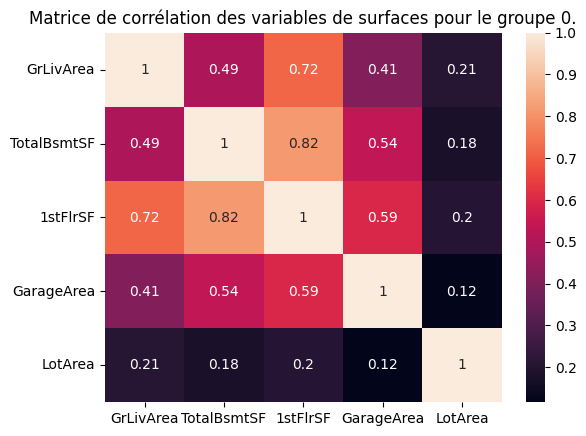

In [241]:
sns.heatmap(
    analyse_set_0[
        ["GrLivArea", "TotalBsmtSF", "1stFlrSF", "GarageArea", "LotArea"]
    ].corr(),
    annot=True,
)
plt.title("Matrice de corrélation des variables de surfaces pour le groupe 0.")
plt.show()

On voit qu'il y a seulement la relation entre la superficie du rez de chaussée et de la superficie totale du sous-sol qui est problématique. Comme la corrélation est grande et en plus l'un ne contient pas l'autre, on peut les additionner.

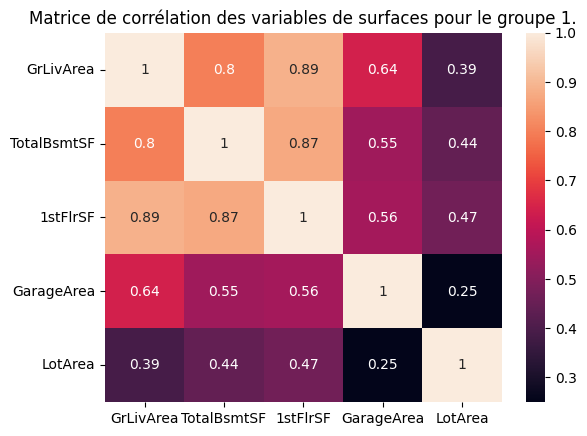

In [242]:
sns.heatmap(
    analyse_set_1[
        ["GrLivArea", "TotalBsmtSF", "1stFlrSF", "GarageArea", "LotArea"]
    ].corr(),
    annot=True,
)
plt.title("Matrice de corrélation des variables de surfaces pour le groupe 1.")
plt.show()

Cette fois-ci, trois relation sont problématique: GrLivArea-TotalBsmtSF, GrLivArea-1stFlrSF, 1stFlrSF-TotalBsmtSF. Comme la surface habitable hors sous-sol contient le rez-de-chaussée, on va supprimer le rez-de-chaussée et additionner la surface habitable avec le sous-sol.

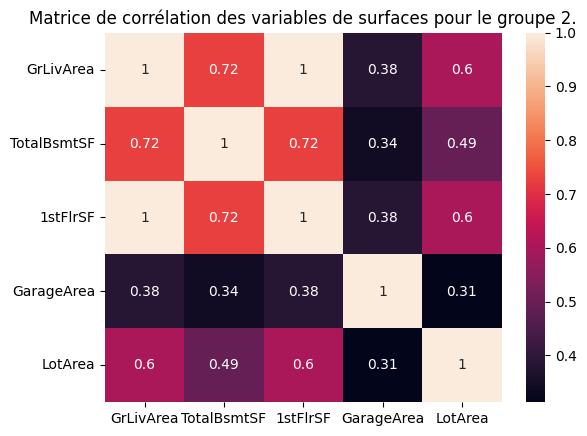

In [244]:
sns.heatmap(
    analyse_set_2[
        ["GrLivArea", "TotalBsmtSF", "1stFlrSF", "GarageArea", "LotArea"]
    ].corr(),
    annot=True,
)
plt.title("Matrice de corrélation des variables de surfaces pour le groupe 2.")
plt.show()

Malgré quelques corrélation assez forte, aucune est problématique. On peut donc utiliser toutes les variables.

In [ ]:
analyse_set_0["HouseArea"] = analyse_set_0["GrLivArea"] + analyse_set_0["TotalBsmtSF"]
analyse_set_1["HouseArea"] = analyse_set_1["GrLivArea"] + analyse_set_1["TotalBsmtSF"]